In [0]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt 
from sklearn.linear_model import LinearRegression
import seaborn as sns
import io
%matplotlib inline
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor 
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
from sklearn.linear_model import Ridge

In [0]:
train_df = pd.read_csv('https://grantmlong.com/data/SE_rents2018_train.csv', index_col=0)
test_df = pd.read_csv('https://grantmlong.com/data/SE_rents2018_test1.csv', index_col=0)
submit1_df = pd.read_csv('https://grantmlong.com/data/SE_rents2018_test2.csv', index_col=0)
submit2_df = pd.read_csv('https://grantmlong.com/data/SE_rents2018_test3.csv', index_col=0)
schools_df = pd.read_csv('https://raw.githubusercontent.com/12NaN/data-science-project/frank/school_data.csv',index_col=0)

train_df = train_df.reset_index().merge(schools_df, on='addr_zip', how='left').set_index(train_df.index.names)
test_df = test_df.reset_index().merge(schools_df, on='addr_zip', how='left').set_index(test_df.index.names)

submit1_df = submit1_df.reset_index().merge(schools_df, on='addr_zip', how='left').set_index(submit1_df.index.names)
submit2_df = submit2_df.reset_index().merge(schools_df, on='addr_zip', how='left').set_index(submit2_df.index.names)

train_df = train_df.drop(train_df[(train_df['size_sqft']>8000) & (train_df['rent']<10000)].index)
train_df = train_df.drop(train_df[(train_df['bathrooms']>=12) & (train_df['rent']<10000)].index)

train_df = train_df.drop(train_df[(train_df['bathrooms']==6) & (train_df['rent']<20000)].index)

train_df = train_df.drop(train_df[(train_df['bedrooms']>=8) & (train_df['rent']<20000)].index)

cf = submit1_df
cf2 = submit2_df

cf = submit1_df #retaining the dataframe in cf instead incase I want to look at the original without edits
cf.min_to_subway = cf.min_to_subway.fillna(cf.min_to_subway.mean(), axis=0) #Replacing empty values with the mean of the entire column
cf.year_built = cf.year_built.fillna(cf.year_built.median(), axis=0) #Replacing empty values with the median of the entire column
cf.loc[cf['size_sqft']==0,'size_sqft'] = np.nan
cf.size_sqft = cf.size_sqft.fillna(cf.size_sqft.mean(), axis=0)


cf2 = submit2_df #retaining the dataframe in cf instead incase I want to look at the original without edits
cf2.min_to_subway = cf2.min_to_subway.fillna(cf2.min_to_subway.mean(), axis=0) #Replacing empty values with the mean of the entire column
cf2.year_built = cf2.year_built.fillna(cf2.year_built.median(), axis=0) #Replacing empty values with the median of the entire column
cf2.loc[cf2['size_sqft']==0,'size_sqft'] = np.nan
cf2.size_sqft = cf2.size_sqft.fillna(cf2.size_sqft.mean(), axis=0)


**Check for Null Columns**

In [429]:
cols_with_null = cf.columns[cf.isna().any()] # Return columns with null values 

cf[cols_with_null].isna().sum().sort_values(ascending=False) 

rent            2000
line             612
Occurrences      397
floornumber      263
unit              29
addr_unit         29
neighborhood       1
dtype: int64

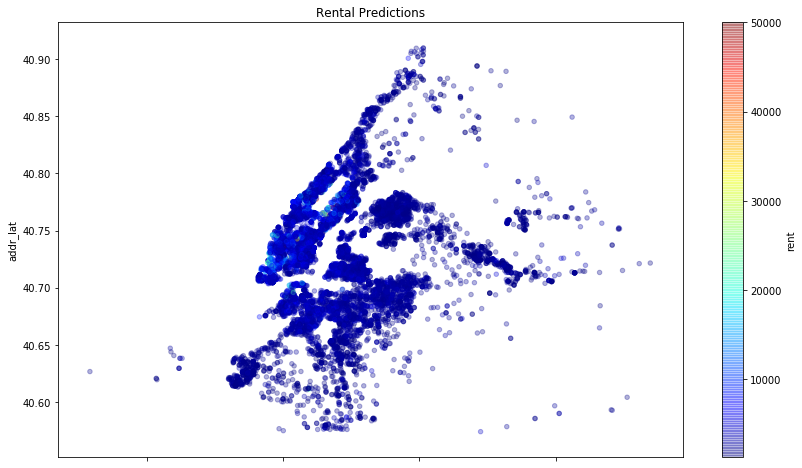

In [463]:
train_df[(train_df['addr_zip'] > 0) ].plot(x='addr_lon', y='addr_lat', kind='scatter', alpha=0.3, c='rent', cmap=plt.get_cmap("jet"), colorbar=True, figsize=(14,8) )
plt.title('Rental Predictions')
plt.show()


**Build training data**

In [0]:
# extract usable features
feature_cols = [
    'bedrooms', 'year_built', 'bathrooms', 'min_to_subway', 
    'size_sqft', 'no_fee', 'has_doorman', 'Occurrences'
]
#Year build and minute values are the only features with missing values
train_features = train_df[feature_cols] 

# impute missing values with medians
train_features = train_features.fillna(train_features.median(), axis=0)

# construct target vector
train_target = train_df['rent']


**Fit model**

In [431]:
lreg = LinearRegression()
lreg.fit(train_features, train_target)

rf = RandomForestRegressor()
rf.fit(train_features, train_target)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

**Predict and Measure Using Test 1**

In [432]:
test_features = test_df[feature_cols] 

# impute missing values with medians
test_features = test_features.fillna(train_features.median(), axis=0)

# construct predictions 
test_df['predicted'] = rf.predict(test_features)

mean_squared_error(test_df['rent'], test_df['predicted'])

2450316.7382421484

**Combine Data, Predict Values for Test 2 USING => KNeighbors**

In [433]:

master_df = train_df.append(test_df, sort=False)

master_df.loc[master_df['size_sqft']==0,'size_sqft'] = np.nan
master_df.size_sqft = master_df.size_sqft.fillna(master_df.size_sqft.mean(), axis=0)

master_features = master_df[feature_cols].fillna(master_df[feature_cols].median(), axis=0)
master_target = master_df['rent']

rf.fit(master_features, master_target)

knn = KNeighborsClassifier() # K-Nearest Neighbors
knn.fit(train_features, train_target)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [434]:
print(cf['rent'].value_counts)

<bound method IndexOpsMixin.value_counts of rental_id
7428577   NaN
7454944   NaN
7473595   NaN
7490488   NaN
7460896   NaN
           ..
7451410   NaN
7493779   NaN
7474525   NaN
7507738   NaN
7443274   NaN
Name: rent, Length: 2000, dtype: float64>


**Create Submission File for test2**

In [435]:
submit1_features = cf[feature_cols].fillna(master_df[feature_cols].median(), axis=0)
cf['predictions'] = knn.predict(submit1_features)
cf['predictions'].to_csv('sample_submission1.csv', header=True)

cf['fake_rent'] = np.ones(cf['predictions'].shape) * master_target.median()
mean_squared_error(cf['predictions'], test_df['rent'])

11236301.0485

**Create Submission File for test3**

In [436]:
submit2_features = cf2[feature_cols].fillna(master_df[feature_cols].median(), axis=0)
cf2['predictions'] = knn.predict(submit2_features)
cf2['predictions'].to_csv('sample_submission2.csv', header=True)

cf2['fake_rent'] = np.ones(cf2['predictions'].shape) * master_target.median()
mean_squared_error(cf2['predictions'], test_df['rent'])

11693457.4555